# FastSam을 활용한 알약 이미지 배경 제거

- 목표 : fastsam을 활용한 알약 이미지 배경 제거   
사용자가 찍은 알약 이미지 데이터의 경우 배경이 다양할 것으로 예상됨, 이에 따라 YOLO 객체 탐지 결과의 영향이 있을 가능성이 높다   
따라서, 알약 이미지 배경 제거를 통해 객체 탐지 효과를 높이는 것을 최종 목표로 한다.

# 모델 테스트

In [138]:
from ultralytics import FastSAM

model = FastSAM("./models/FastSAM-s.pt")

In [139]:
source = "./images/original/test1.jpg"

results = model(source, device="cpu", save=True, retina_masks=True, conf=0.8, iou=0.8)


image 1/1 c:\Potenup\Drug-Detection-Chatbot\modeling\segment\images\original\test1.jpg: 640x384 4 objects, 105.7ms
Speed: 1.8ms preprocess, 105.7ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to C:\Potenup\DeepLearning-YOLO-Study\runs\segment\predict11


In [140]:
masks = results[0].masks
boxes = results[0].boxes

In [141]:
for box in boxes:
    print(box.data)

tensor([[235.5867, 476.9659, 339.2986, 672.8390,   0.9612,   0.0000]])
tensor([[2.2503e+02, 7.8327e+02, 4.7533e+02, 9.5500e+02, 9.5258e-01, 0.0000e+00]])
tensor([[452.2988, 414.0807, 594.8429, 559.6519,   0.9517,   0.0000]])
tensor([[467.5223, 610.0718, 637.2809, 780.8293,   0.9430,   0.0000]])


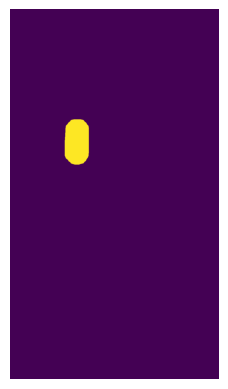

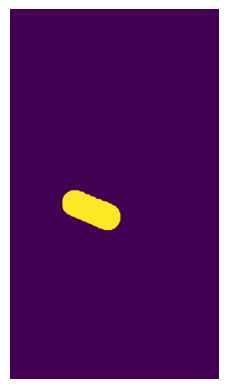

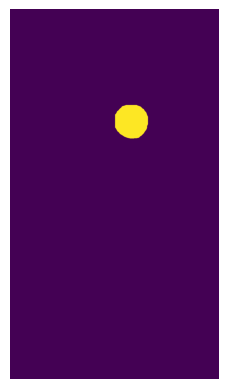

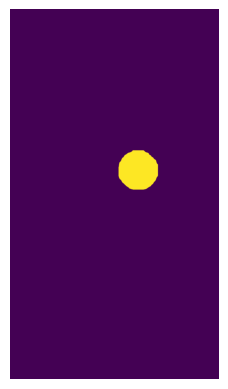

In [142]:
import matplotlib.pyplot as plt

for mask in masks.data:
    plt.imshow(mask)
    plt.axis("off")
    plt.show()

# 데이터 불러오기

In [143]:
original_image_path = "./images/original/"
result_image_path = "./images/results/"

In [144]:
import matplotlib.pyplot as plt
import cv2

In [145]:
# 테스트용 데이터를 불러옵니다
source_path = "test1.jpg"
test_image_source = original_image_path + source_path

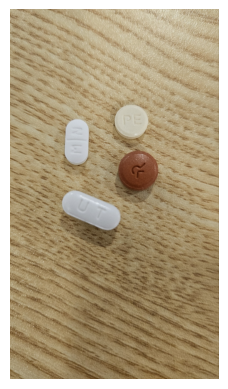

In [146]:
original_image = cv2.imread(test_image_source)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.axis("off")
plt.show()

## 예상 되는 문제와 해결 방법

### 1) 알약과 비슷한 색의 배경의 경우 객체 탐지가 어려울 수 있음

해결 방법:
- 흰 배경/흰 물체는 색상보다 밝기 차를 활용해야함, RGB→LAB/HSV로 바꿔 L(밝기) 또는 S(채도) 기반 대비 높임
- CLAHE(밝기 채널 국부 대비 향상), 샤픈/언샵 마스크, 에지 강화(가우시안 후 Canny)로 알약과 배경사이의 경계 특징을 증강
- 배경이 완전 흰색이면 미세한 음영/그림자가 힌트이므로 감마 보정(γ<1) 활용

### 2) 알약이 아닌 데이터 또한 탐지
알약 이외의 배경과 확연이 구분되는 물체나 글자 등이 탐지 될 수 있다

해결 방법:
- 후처리 필터링
    - 크기(면적) 필터링: 
        - 알약의 일반적인 크기 범위를 벗어나는 매우 작거나 큰 영역은 제외 
        ex) 배경의 작은 점이나 얼룩, 또는 알약 전체 면적을 훨씬 초과하는 큰 물체를 제거
    - 형태(종횡비, 원형도) 필터링: 
        - 알약은 보통 원형 또는 타원형에 가까움
        - 종횡비(aspect ratio)가 매우 크거나 불규칙한 형태의 영역을 제외하여 글자나 기타 배경 노이즈를 제거
    - 색상 필터링: 특정 색상의 배경 노이즈(예: 검은색 글자)를 제거

- 도메인 특화 모델 미세 조정(Fine-tuning): 알약 이미지 데이터셋에 대해 FastSAM을 추가로 학습(fine-tuning)

# 데이터 전처리

## LAB 변환

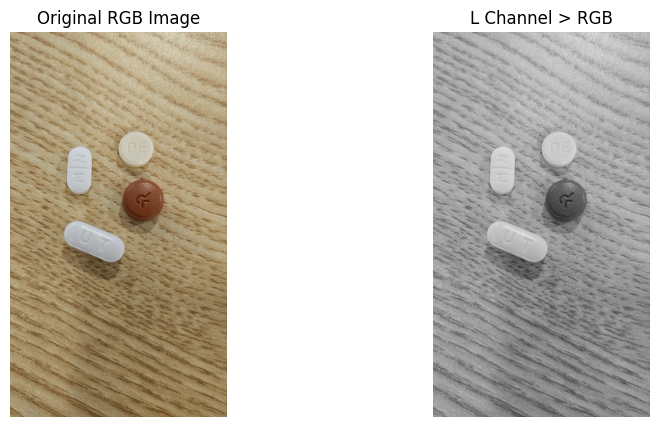

In [147]:
import cv2
import matplotlib.pyplot as plt

def adjust_lab(image):
    # RGB 이미지를 LAB 색 공간으로 변환
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # L(밝기), A(초록-빨강), B(파랑-노랑) 채널로 분리
    l_channel, _, _ = cv2.split(image_lab)
    l_channel_image = cv2.cvtColor(l_channel, cv2.COLOR_GRAY2RGB)

    return l_channel_image

# Test
l_channel_image = adjust_lab(original_image)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(l_channel_image, cmap='gray')
plt.title('L Channel > RGB')
plt.axis('off')

plt.show()

## 감마 보정(γ<1)
감마 보정은 이미지의 전체적인 밝기 분포를 조절하는 기법입니다. 픽셀 값에 감마(γ) 값을 적용하여 새로운 픽셀 값을 계산합니다.

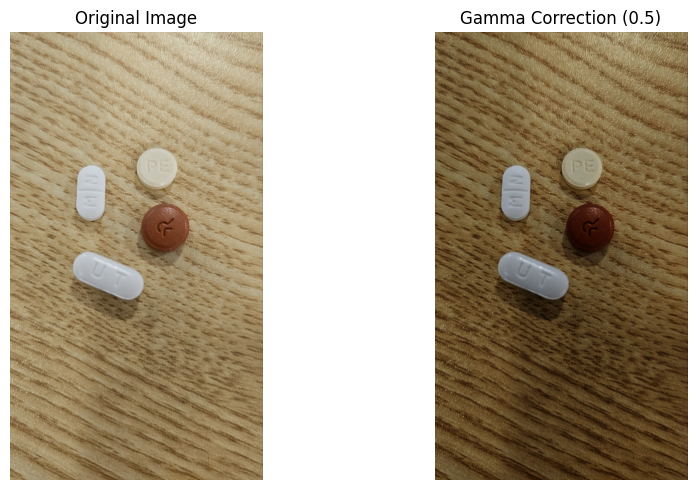

In [148]:
# 대비 높이기
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    # LUT(Look-Up Table)를 사용하여 픽셀 값을 매핑합니다.
    # 256개 픽셀 값(0-255)에 대해 미리 계산된 감마 보정 값을 저장합니다.
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # LUT를 적용하여 이미지를 변환합니다.
    return cv2.LUT(image, table)

# Test
gamma_low = 0.5  # 이미지를 더 밝게 (음영 강조)
gamma_image_low = adjust_gamma(original_image, gamma=gamma_low)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gamma_image_low)
axes[1].set_title(f'Gamma Correction ({gamma_low})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [149]:
train_image = gamma_image_low

# FastSam 마스킹

In [150]:
from ultralytics import FastSAM

model = FastSAM("./models/FastSAM-s.pt")

In [151]:
results = model(train_image, device="cpu", save=True, retina_masks=True, conf=0.8, iou=0.8)


0: 640x384 4 objects, 104.8ms
Speed: 1.9ms preprocess, 104.8ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to C:\Potenup\DeepLearning-YOLO-Study\runs\segment\predict12


In [152]:
masks = results[0].masks.data
boxes = results[0].boxes

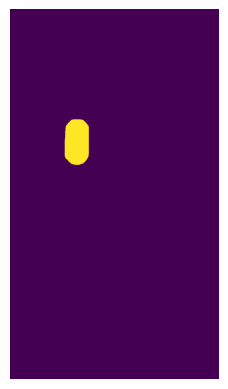

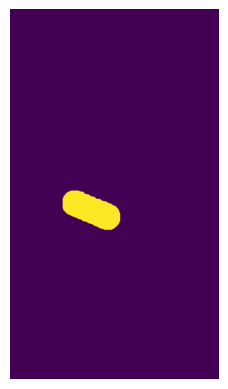

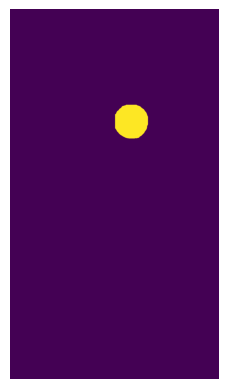

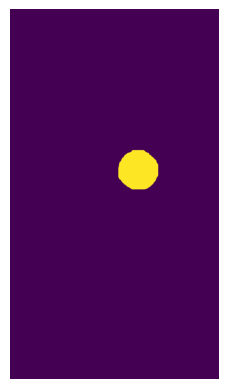

In [153]:
import matplotlib.pyplot as plt

for mask in masks:
    plt.imshow(mask)
    plt.axis("off")
    plt.show()

# 배경 제거

In [ ]:
if len(masks) == 0:
    print("No objects detected. No mask generated.")
else:
    # 모든 객체의 마스크를 통합
    combined_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    for mask_tensor in masks:
        mask_array = mask_tensor.cpu().numpy().astype(np.uint8)
        combined_mask = cv2.bitwise_or(combined_mask, mask_array)

    # 배경 제거 및 투명 배경 PNG 저장
    image_rgba = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)
    image_rgba[:, :, 3] = combined_mask * 255

    # 결과 이미지 저장
    output_path = result_image_path + ''.join(source_path.split('.')[:-1]) + '.png'
    cv2.imwrite(output_path, image_rgba)
    print(f"Image with transparent background saved to {output_path}")

Image with transparent background saved to ./images/results/test1.png
